In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "hi",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7744 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['D00', 'D40']

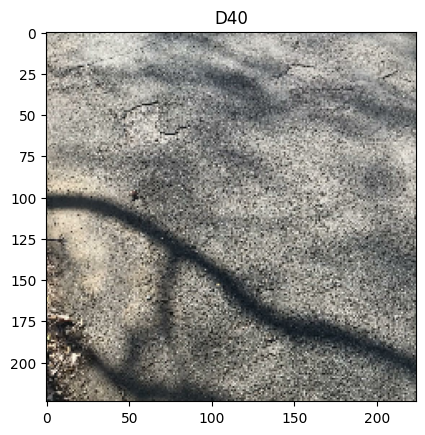

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("on")

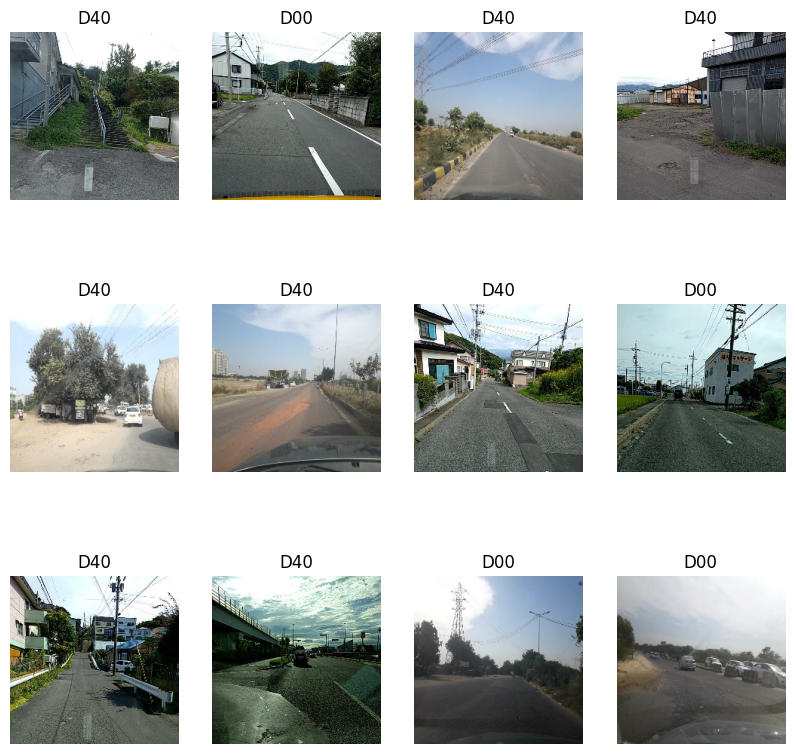

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

242

In [10]:
train_size = 0.8
len(dataset)*train_size

193.60000000000002

In [11]:
train_ds = dataset.take(193)
len(train_ds)

193

In [12]:
test_ds = dataset.skip(193)
len(test_ds)

49

In [13]:
val_size=0.1
len(dataset)*val_size

24.200000000000003

In [14]:
val_ds = test_ds.take(24)
len(val_ds)

24

In [15]:
test_ds = test_ds.skip(24)
len(test_ds)

25

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

193

In [19]:
len(val_ds)

24

In [20]:
len(test_ds)

25

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


193/193 [==============================] - 108s 513ms/step - loss: 0.6710 - accuracy: 0.6046 - val_loss: 0.6095 - val_accuracy: 0.6680
Epoch 2/50
193/193 [==============================] - 94s 485ms/step - loss: 0.6359 - accuracy: 0.6514 - val_loss: 0.5982 - val_accuracy: 0.6862
Epoch 3/50
193/193 [==============================] - 93s 479ms/step - loss: 0.6262 - accuracy: 0.6540 - val_loss: 0.6300 - val_accuracy: 0.6745
Epoch 4/50
193/193 [==============================] - 99s 511ms/step - loss: 0.6254 - accuracy: 0.6540 - val_loss: 0.6089 - val_accuracy: 0.6810
Epoch 5/50
193/193 [==============================] - 93s 480ms/step - loss: 0.6188 - accuracy: 0.6577 - val_loss: 0.5972 - val_accuracy: 0.6732
Epoch 6/50
193/193 [==============================] - 92s 477ms/step - loss: 0.6083 - accuracy: 0.6687 - val_loss: 0.5748 - val_accuracy: 0.6953
Epoch 7/50
193/193 [==============================] - 92s 475ms/step - loss: 0.6009 - accuracy: 0.6745 - val_loss: 0.5767 - val

In [29]:
scores = model.evaluate(test_ds)

25/25 [==============================] - 8s 106ms/step - loss: 0.5120 - accuracy: 0.7462


In [30]:
scores

[0.5120030045509338, 0.7462499737739563]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 193}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

50

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

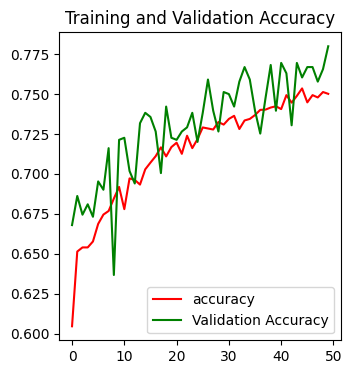

In [37]:
Epoch = len(acc)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(Epoch), acc,color='red', label='accuracy')
plt.plot(range(Epoch), val_acc,color='green', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


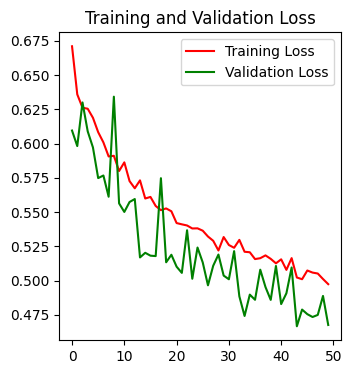

In [38]:
EPOCHS=len(loss)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss,color='red', label='Training Loss')
plt.plot(range(EPOCHS), val_loss,color='green', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: D00
1/1 [==============================] - 0s 296ms/step
predicted label: D00


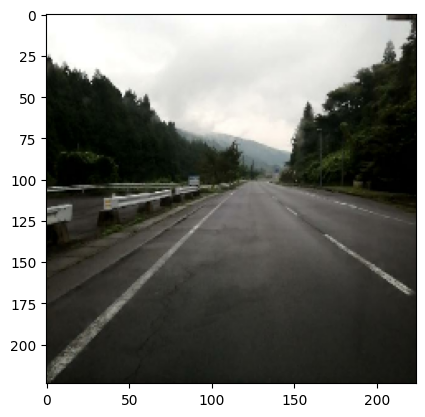

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


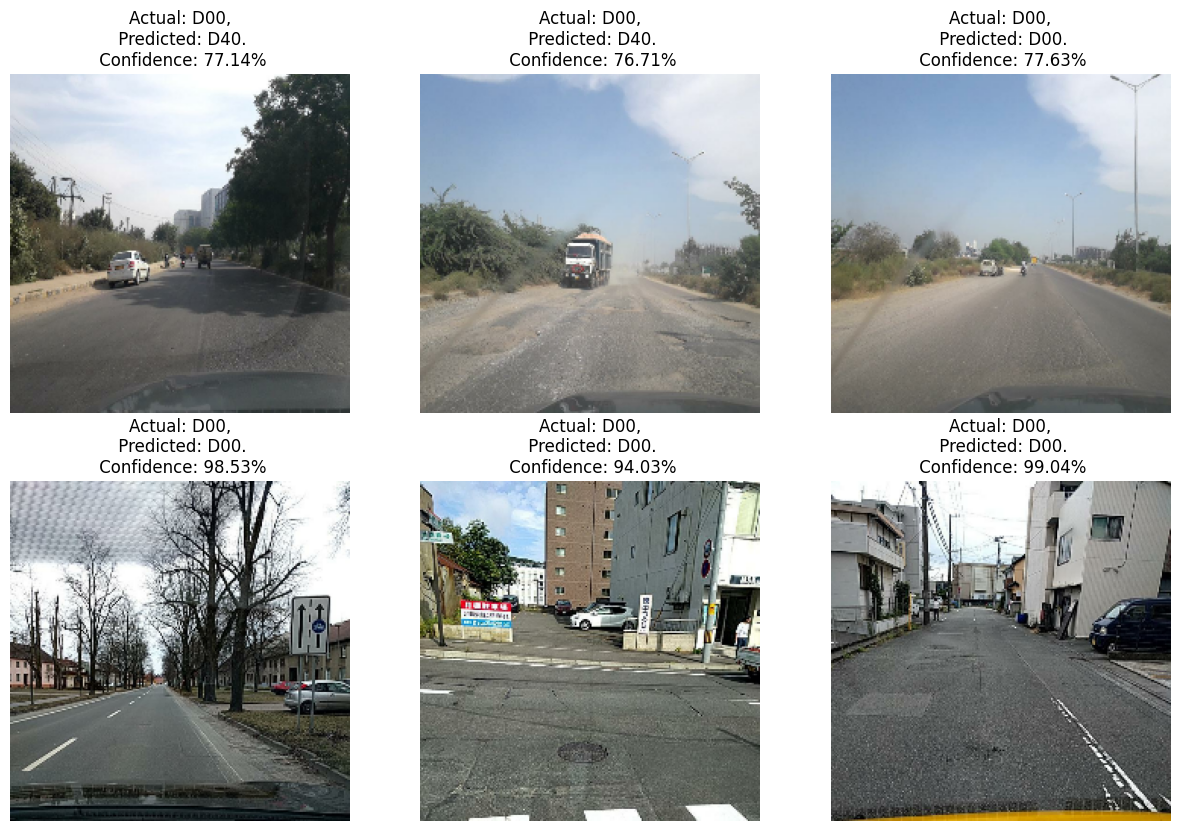

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 147ms/step


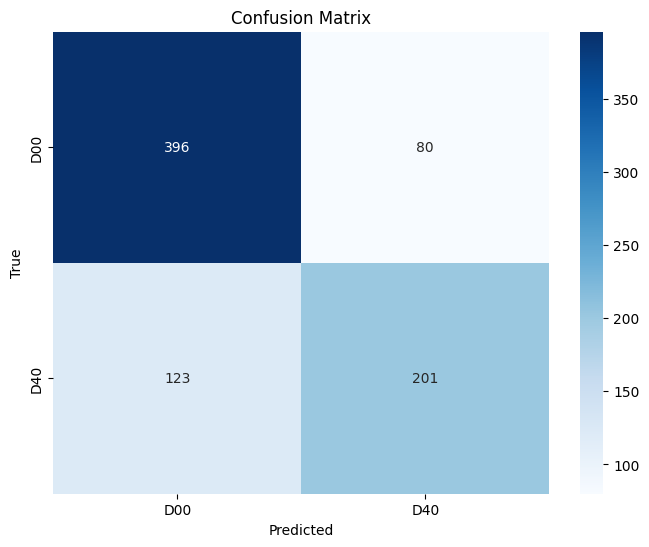

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create lists to store ground truth and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset
for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # Ground truth labels
    predictions = model.predict(images)  # Predict labels
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [43]:
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.742715478217534


In [44]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.74625


In [45]:
model.save("model1.h5")

c:\Users\tharu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 22ms/step


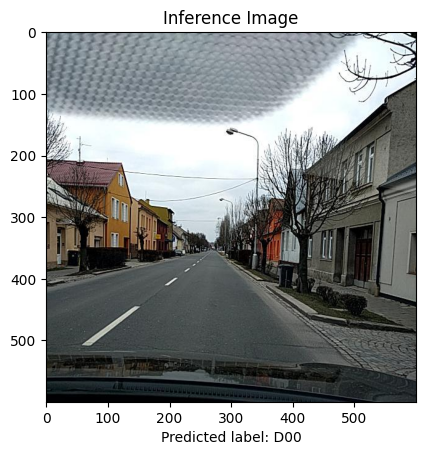

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your image
image_path = r"Final_train\D00\Czech_000055.jpg"


# Load the image
image = Image.open(image_path)

# Convert the image to numpy array
inference_image_np = np.array(image).astype('uint8')

# Perform inference on the inference image
inference_prediction = model.predict(np.expand_dims(inference_image_np, axis=0))

# Get the predicted label
predicted_label = class_names[np.argmax(inference_prediction)]

# Display the inference image and predicted label
plt.imshow(inference_image_np)
plt.title("Inference Image")
plt.xlabel("Predicted label: " + predicted_label)
plt.show()
